# Libraries / Dependencies

In [8]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from pathlib import Path
from tqdm import tqdm
import shutil
from sklearn.model_selection import train_test_split
import pandas as pd
from collections import Counter

# Class Artstyle
 Using Dataset

In [10]:
class ArtStyleDataset(Dataset):
    """
    Dataset do pracy z obrazami podzielonymi według stylów artystycznych.
    """
    def __init__(self, data_dir, transform=None, mode='train'):
       
        self.data_dir = Path(data_dir) / mode
        self.transform = transform
        self.mode = mode
        
        self.images = []
        self.labels = []
        self.label_to_idx = {}
        
        for style_dir in self.data_dir.iterdir():
            if style_dir.is_dir():
                style_name = style_dir.name
                
                if style_name not in self.label_to_idx:
                    self.label_to_idx[style_name] = len(self.label_to_idx)
                
                for img_path in style_dir.glob('*.jpg'):
                    self.images.append(str(img_path))
                    self.labels.append(self.label_to_idx[style_name])
        
        self.idx_to_label = {v: k for k, v in self.label_to_idx.items()}
        print(f"Znaleziono {len(self.images)} obrazów w zbiorze {mode} z {len(self.label_to_idx)} klasami")
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        if self.transform:
            img = self.transform(img)
        
        return img, label, img_path


# Image Processing

In [11]:
def preprocess_images(input_dir, output_dir, target_size=(512, 512)):
    """
    Przetwarza obrazy z folderu wejściowego i zapisuje je w folderze wyjściowym
    z zachowaniem struktury katalogów (stylu artystycznego).
    """
    input_path = Path(input_dir)
    output_path = Path(output_dir)
    
    output_path.mkdir(parents=True, exist_ok=True)
    
    style_dirs = [d for d in input_path.iterdir() if d.is_dir()]
    
    # foldery podfolderow sama nie wiem juz ile tych folderow
    for style_dir in style_dirs:
        style_name = style_dir.name
        output_style_dir = output_path / style_name
        output_style_dir.mkdir(exist_ok=True)
        
        sub_dirs = [d for d in style_dir.iterdir() if d.is_dir()]
        
        if sub_dirs:
            for sub_dir in sub_dirs:
                image_files = list(sub_dir.glob('*.jpg')) 
                print(f"Przetwarzanie {len(image_files)} obrazów w stylu {style_name}")
                
                for img_path in tqdm(image_files, desc=f"Styl: {style_name}"):
                    process_image(img_path, output_style_dir, target_size)
        else:
            image_files = list(style_dir.glob('*.jpg'))
            print(f"Przetwarzanie {len(image_files)} obrazów w stylu {style_name}")
            
            for img_path in tqdm(image_files, desc=f"Styl: {style_name}"):
                process_image(img_path, output_style_dir, target_size)
    
    print("Zakończono preprocessing obrazów!")

def process_image(img_path, output_dir, target_size):
    """
    Przetwarza pojedynczy obraz.
    """
    try:
        img = cv2.imread(str(img_path))
        if img is None:
            print(f"Nie udało się wczytać: {img_path}")
            return
        
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  #BGR na RGB
        
        h, w = img.shape[:2]
        aspect_ratio = w / h
        
        if aspect_ratio > 3 or aspect_ratio < 1/3: 
            if w > h:
                new_w = int(h * 1.5)  
                start_x = int((w - new_w) / 2)
                img = img[:, start_x:start_x+new_w]
            else:
                new_h = int(w * 1.5) 
                start_y = int((h - new_h) / 2)
                img = img[start_y:start_y+new_h, :]
        

        h, w = img.shape[:2]
        if w > h:
            new_w = min(w, target_size[0])
            new_h = int(h * (new_w / w))
        else:
            new_h = min(h, target_size[1])
            new_w = int(w * (new_h / h))
        
        img_resized = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)
        
        # padding
        padded_img = np.zeros((target_size[1], target_size[0], 3), dtype=np.uint8)
        
        start_x = (target_size[0] - new_w) // 2
        start_y = (target_size[1] - new_h) // 2
        padded_img[start_y:start_y+new_h, start_x:start_x+new_w] = img_resized
        
        output_file = output_dir / img_path.name
        cv2.imwrite(str(output_file), cv2.cvtColor(padded_img, cv2.COLOR_RGB2BGR))
        
    except Exception as e:
        print(f"Błąd podczas przetwarzania {img_path}: {e}")

# Datasplitting
train, validation, test

In [12]:
def split_data_with_balancing(processed_dir, output_dir, 
                             train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, 
                             min_class_size=2000, max_class_size=3000,
                             random_state=42):
   
    assert train_ratio + val_ratio + test_ratio == 1.0, "Proporcje podziału muszą sumować się do 1.0"
    
    processed_path = Path(processed_dir)
    output_path = Path(output_dir)
    
    # Tymczasowy katalog dla zbalansowanych danych
    balanced_path = output_path / "balanced_temp"
    if balanced_path.exists():
        shutil.rmtree(balanced_path)
    balanced_path.mkdir(parents=True, exist_ok=True)
    
    # Katalogi dla zbiorów finalnych
    train_dir = output_path / "train"
    val_dir = output_path / "val"
    test_dir = output_path / "test"
    
    for directory in [train_dir, val_dir, test_dir]:
        if directory.exists():
            shutil.rmtree(directory)
        directory.mkdir(parents=True, exist_ok=True)
    
    style_dirs = [d for d in processed_path.iterdir() if d.is_dir()]
    
    print("Rozpoczynam balansowanie klas...")
    
    balanced_files = {}
    
    # ETAP 1: Balansowanie każdej klasy
    for style_dir in style_dirs:
        style_name = style_dir.name
        print(f"\nPrzetwarzanie stylu: {style_name}")
        
        balanced_style_dir = balanced_path / style_name
        balanced_style_dir.mkdir(exist_ok=True)
        
        image_files = list(style_dir.glob('*.jpg'))
        total_images = len(image_files)
        print(f"Znaleziono {total_images} oryginalnych obrazów")
        
        balanced_files[style_name] = []
        
        # 1. Redukcja 
        if total_images > max_class_size:
            print(f"Redukcja liczby obrazów z {total_images} do {max_class_size}")
            random.seed(random_state)
            selected_files = random.sample(image_files, max_class_size)
            
            for src_file in selected_files:
                dst_file = balanced_style_dir / src_file.name
                shutil.copy2(src_file, dst_file)
                balanced_files[style_name].append(dst_file)
                
        # 2. Oversamplig dla małych klas
        elif total_images < min_class_size:
            print(f"Klasa {style_name} ma {total_images} obrazów - mniej niż {min_class_size}. Rozpoczynam uproszczony oversamplig.")
            
            for src_file in image_files:
                dst_file = balanced_style_dir / src_file.name
                shutil.copy2(src_file, dst_file)
                balanced_files[style_name].append(dst_file)
            
            oversample_needed = min_class_size - total_images
            
            copies_per_image = oversample_needed // total_images + 1
            
            rotation_angles = [-5, -3, 3, 5]  # kąty obrotu
            # brightness_adjustments = [-25, -15, 15, 25] 
            
            augmented_count = 0
            for src_file in tqdm(image_files, desc="Augmentacja obrazów"):
                for angle in rotation_angles:
                    if augmented_count >= oversample_needed:
                        break

                    img = cv2.imread(str(src_file))
                    if img is None:
                        continue
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                    h, w = img.shape[:2]
                    center = (w // 2, h // 2)
                    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
                    rotated = cv2.warpAffine(img, rotation_matrix, (w, h))

                    augmented_name = f"{src_file.stem}_aug_r{angle}{src_file.suffix}"
                    augmented_path = balanced_style_dir / augmented_name
                    cv2.imwrite(str(augmented_path), cv2.cvtColor(rotated, cv2.COLOR_RGB2BGR))
                    balanced_files[style_name].append(augmented_path)
                    augmented_count += 1

            
            print(f"Utworzono {augmented_count} augmentowanych obrazów")
            
        # 3. Odpowiednia wielkość (kopiuje i tyle)
        else:
            print(f"Klasa {style_name} ma odpowiednią liczbę obrazów ({total_images}). Kopiowanie bez zmian.")
            for src_file in image_files:
                dst_file = balanced_style_dir / src_file.name
                shutil.copy2(src_file, dst_file)
                balanced_files[style_name].append(dst_file)
    
    print("\nZakończono balansowanie klas. Dzielenie na zbiory...")
    
    # Stats
    dataset_stats = {
        'train': Counter(),
        'val': Counter(),
        'test': Counter()
    }
    
    # ETAP 2: Podział na zbiory treningowy, walidacyjny i testowy
    for style_name, files in balanced_files.items():
        print(f"Dzielenie klasy {style_name} na zbiory...")
        
        (train_dir / style_name).mkdir(exist_ok=True)
        (val_dir / style_name).mkdir(exist_ok=True)
        (test_dir / style_name).mkdir(exist_ok=True)
        
        random.seed(random_state)
        random.shuffle(files)
        
        train_size = int(len(files) * train_ratio)
        val_size = int(len(files) * val_ratio)
        
        train_files = files[:train_size]
        val_files = files[train_size:train_size+val_size]
        test_files = files[train_size+val_size:]
        
        for src_file in train_files:
            dst_file = train_dir / style_name / src_file.name
            shutil.copy2(src_file, dst_file)
        
        for src_file in val_files:
            dst_file = val_dir / style_name / src_file.name
            shutil.copy2(src_file, dst_file)
        
        for src_file in test_files:
            dst_file = test_dir / style_name / src_file.name
            shutil.copy2(src_file, dst_file)
        
        # Aktualizuj statystyki
        dataset_stats['train'][style_name] = len(train_files)
        dataset_stats['val'][style_name] = len(val_files)
        dataset_stats['test'][style_name] = len(test_files)
        
        print(f"  - Zbiór treningowy: {dataset_stats['train'][style_name]} obrazów")
        print(f"  - Zbiór walidacyjny: {dataset_stats['val'][style_name]} obrazów")
        print(f"  - Zbiór testowy: {dataset_stats['test'][style_name]} obrazów")
    
    shutil.rmtree(balanced_path)
    
    print("\nZakończono podział danych na zbiory!")
    return dataset_stats

# Data distribution between categories

In [13]:
def plot_class_distribution(dataset_stats):
    """
    Tworzy wykresy kołowe przedstawiające rozkład klas w każdym ze zbiorów.
    """
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    
    for i, dataset_type in enumerate(['train', 'val', 'test']):
        stats = dataset_stats[dataset_type]
        labels = list(stats.keys())
        values = list(stats.values())
        
        axs[i].pie(values, labels=None, autopct='%1.1f%%', startangle=90)
        axs[i].set_title(f'Rozkład klas w zbiorze {dataset_type}')
    
    # Dodaj wspólną legendę
    fig.legend(labels, loc='lower center', ncol=min(5, len(labels)))
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)
    plt.savefig('class_distribution.png')
    plt.show()
    
    # Tworzymy też wykres słupkowy dla lepszego porównania
    df = pd.DataFrame(dataset_stats)
    df.plot(kind='bar', figsize=(12, 6))
    plt.title('Liczba obrazów w każdej klasie według zbioru')
    plt.xlabel('Klasa')
    plt.ylabel('Liczba obrazów')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('class_distribution_bar.png')
    plt.show()

def denormalize(img_tensor, mean, std):
    """
    Odwraca normalizację obrazu (tensor PyTorch) do zakresu [0,1].
    """
    mean = torch.tensor(mean).view(-1, 1, 1)
    std = torch.tensor(std).view(-1, 1, 1)
    return img_tensor * std + mean

def plot_class_examples(dataset, num_examples=5):
    """
    Wyświetla przykładowe obrazy z każdej klasy z oryginalnymi kolorami.
    """
    
    # Grupuj indeksy według klas
    class_indices = {}
    for idx, (_, label, _) in enumerate(dataset):
        if label not in class_indices:
            class_indices[label] = []
        class_indices[label].append(idx)
    
    # Dla każdej klasy wyświetl przykłady
    for label, indices in class_indices.items():
        class_name = dataset.idx_to_label[label]
        
        sample_indices = random.sample(indices, min(num_examples, len(indices)))
        
        fig, axs = plt.subplots(1, len(sample_indices), figsize=(15, 3))
        fig.suptitle(f'Przykłady klasy: {class_name}')
        
        for i, idx in enumerate(sample_indices):
            img, _, img_path = dataset[idx]
            
            # Konwersja z PyTorch tensor do formatu odpowiedniego dla matplotlib
            if isinstance(img, torch.Tensor):
                if img.dim() == 3 and img.shape[0] in [1, 3, 4]:  # jeśli [C, H, W]
                    img = denormalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                    img = img.permute(1, 2, 0).cpu().numpy()
                    img = np.clip(img, 0, 1)  # żeby wartości nie wyszły poza zakres [0, 1]
                    
                    if img.shape[2] == 1:
                        img = img.squeeze(2)
                else:
                    img = img.cpu().numpy()
            
            if len(sample_indices) == 1:
                axs.imshow(img)
                axs.set_title(Path(img_path).name)
                axs.axis('off')
            else:
                axs[i].imshow(img)
                axs[i].set_title(Path(img_path).name)
                axs[i].axis('off')
        
        plt.tight_layout()
        plt.show()


# Dataloaders

In [14]:
def create_data_loaders(data_dir, batch_size=32, img_size=224, num_workers=4):
    """
    Tworzy DataLoadery dla zbiorów treningowego, walidacyjnego i testowego.
    """
    # Transformacje dla zbioru treningowego (z augmentacją - losowe przycięcie, odbicie lustrzane, rotacja)
    train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Transformacje dla zbiorów walidacyjnego i testowego (bez augmentacji)
    val_test_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(img_size + 32),
        transforms.CenterCrop(img_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Datasety
    train_dataset = ArtStyleDataset(data_dir, transform=train_transform, mode='train')
    val_dataset = ArtStyleDataset(data_dir, transform=val_test_transform, mode='val')
    test_dataset = ArtStyleDataset(data_dir, transform=val_test_transform, mode='test')
    
    # DataLoadery
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_dataset, 
        batch_size=batch_size, 
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )
    
    test_loader = DataLoader(
        test_dataset, 
        batch_size=batch_size, 
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )
    
    return {
        'train_loader': train_loader,
        'val_loader': val_loader,
        'test_loader': test_loader,
        'train_dataset': train_dataset,
        'val_dataset': val_dataset,
        'test_dataset': test_dataset,
        'train_transform': train_transform,
        'val_test_transform': val_test_transform
    }

# Main

In [15]:
# Ścieżki do katalogów
input_directory = r"C:\Users\kkuro\Desktop\Studia\semestr_6\Podstawy_AI\DataSet"
output_directory = r"C:\Users\kkuro\Desktop\Studia\semestr_6\Podstawy_AI\outData"

# Parametry
target_size = (512, 512)
img_size = 224
batch_size = 32
min_class_size = 2000
max_class_size = 3000

# Ścieżki wyjściowe
processed_dir = os.path.join(output_directory, "processed")
split_dir = os.path.join(output_directory, "split")

In [ ]:
#print("\n--- ETAP 1: Preprocessing obrazów ---")
#preprocess_images(input_directory, processed_dir, target_size=target_size)


--- ETAP 1: Preprocessing obrazów ---
Przetwarzanie 1305 obrazów w stylu Academic_Art


Styl: Academic_Art:   0%|          | 0/1305 [00:00<?, ?it/s]

Styl: Academic_Art: 100%|██████████| 1305/1305 [00:29<00:00, 43.92it/s] 


Przetwarzanie 3035 obrazów w stylu Art_Nouveau


Styl: Art_Nouveau:  18%|█▊        | 546/3035 [00:22<01:14, 33.45it/s]

Nie udało się wczytać: C:\Users\kkuro\Desktop\Studia\semestr_6\Podstawy_AI\DataSet\Art_Nouveau\Art_Nouveau\245733.jpg


Styl: Art_Nouveau: 100%|██████████| 3035/3035 [01:09<00:00, 43.51it/s] 


Przetwarzanie 5312 obrazów w stylu Baroque


Styl: Baroque:  14%|█▍        | 750/5312 [00:14<01:38, 46.09it/s] 

Nie udało się wczytać: C:\Users\kkuro\Desktop\Studia\semestr_6\Podstawy_AI\DataSet\Baroque\Baroque\220102.jpg
Nie udało się wczytać: C:\Users\kkuro\Desktop\Studia\semestr_6\Podstawy_AI\DataSet\Baroque\Baroque\220106.jpg


Styl: Baroque:  28%|██▊       | 1468/5312 [00:29<01:38, 39.09it/s]

Nie udało się wczytać: C:\Users\kkuro\Desktop\Studia\semestr_6\Podstawy_AI\DataSet\Baroque\Baroque\232176.jpg


Styl: Baroque:  28%|██▊       | 1509/5312 [00:30<01:29, 42.66it/s]

Nie udało się wczytać: C:\Users\kkuro\Desktop\Studia\semestr_6\Podstawy_AI\DataSet\Baroque\Baroque\232223.jpg


Styl: Baroque: 100%|██████████| 5312/5312 [02:04<00:00, 42.76it/s] 


Przetwarzanie 2607 obrazów w stylu Expressionism


Styl: Expressionism: 100%|██████████| 2607/2607 [01:05<00:00, 39.78it/s] 


Przetwarzanie 2235 obrazów w stylu Japanese_Art


Styl: Japanese_Art:  16%|█▌        | 362/2235 [00:12<00:36, 51.62it/s]

Nie udało się wczytać: C:\Users\kkuro\Desktop\Studia\semestr_6\Podstawy_AI\DataSet\Japanese_Art\Japanese_Art\223666.jpg


Styl: Japanese_Art:  42%|████▏     | 949/2235 [00:30<00:19, 65.25it/s]

Nie udało się wczytać: C:\Users\kkuro\Desktop\Studia\semestr_6\Podstawy_AI\DataSet\Japanese_Art\Japanese_Art\242432.jpg


Styl: Japanese_Art: 100%|██████████| 2235/2235 [00:55<00:00, 39.94it/s] 


Przetwarzanie 3115 obrazów w stylu Neoclassicism


Styl: Neoclassicism: 100%|██████████| 3115/3115 [01:15<00:00, 41.23it/s] 


Przetwarzanie 1324 obrazów w stylu Primitivism


Styl: Primitivism: 100%|██████████| 1324/1324 [00:23<00:00, 56.16it/s] 


Przetwarzanie 5373 obrazów w stylu Realism


Styl: Realism: 100%|██████████| 5373/5373 [01:30<00:00, 59.45it/s] 


Przetwarzanie 6192 obrazów w stylu Renaissance


Styl: Renaissance:  64%|██████▍   | 3982/6192 [01:18<00:37, 59.42it/s] 

Nie udało się wczytać: C:\Users\kkuro\Desktop\Studia\semestr_6\Podstawy_AI\DataSet\Renaissance\Renaissance\241406.jpg


Styl: Renaissance:  70%|██████▉   | 4322/6192 [01:25<00:40, 46.04it/s]

Nie udało się wczytać: C:\Users\kkuro\Desktop\Studia\semestr_6\Podstawy_AI\DataSet\Renaissance\Renaissance\249071.jpg


Styl: Renaissance: 100%|██████████| 6192/6192 [02:34<00:00, 40.18it/s] 


Przetwarzanie 2521 obrazów w stylu Rococo


Styl: Rococo: 100%|██████████| 2521/2521 [00:51<00:00, 49.42it/s] 


Przetwarzanie 6813 obrazów w stylu Romanticism


Styl: Romanticism:  38%|███▊      | 2581/6813 [00:37<00:48, 87.75it/s] 

Nie udało się wczytać: C:\Users\kkuro\Desktop\Studia\semestr_6\Podstawy_AI\DataSet\Romanticism\Romanticism\209824.jpg


Styl: Romanticism: 100%|██████████| 6813/6813 [02:00<00:00, 56.66it/s] 


Przetwarzanie 1510 obrazów w stylu Symbolism


Styl: Symbolism: 100%|██████████| 1510/1510 [00:29<00:00, 51.86it/s]


Przetwarzanie 1158 obrazów w stylu Western_Medieval


Styl: Western_Medieval: 100%|██████████| 1158/1158 [00:47<00:00, 24.15it/s]

Zakończono preprocessing obrazów!


In [ ]:
# print("\n--- ETAP 2: Podział na zbiory treningowy, walidacyjny i testowy z balansowaniem klas ---")
# dataset_stats = split_data_with_balancing(
#     processed_dir,
#     split_dir,
#     train_ratio=0.7,
#     val_ratio=0.15,
#     test_ratio=0.15,
#     min_class_size=min_class_size,
#     max_class_size=max_class_size
# )


--- ETAP 2: Podział na zbiory treningowy, walidacyjny i testowy z balansowaniem klas ---
Rozpoczynam balansowanie klas...

Przetwarzanie stylu: Academic_Art
Znaleziono 1305 oryginalnych obrazów
Klasa Academic_Art ma 1305 obrazów - mniej niż 2000. Rozpoczynam uproszczony oversamplig.


Augmentacja obrazów: 100%|██████████| 1305/1305 [00:02<00:00, 437.36it/s]


Utworzono 695 augmentowanych obrazów

Przetwarzanie stylu: Art_Nouveau
Znaleziono 3034 oryginalnych obrazów
Redukcja liczby obrazów z 3034 do 3000

Przetwarzanie stylu: Baroque
Znaleziono 5308 oryginalnych obrazów
Redukcja liczby obrazów z 5308 do 3000

Przetwarzanie stylu: Expressionism
Znaleziono 2607 oryginalnych obrazów
Klasa Expressionism ma odpowiednią liczbę obrazów (2607). Kopiowanie bez zmian.

Przetwarzanie stylu: Japanese_Art
Znaleziono 2233 oryginalnych obrazów
Klasa Japanese_Art ma odpowiednią liczbę obrazów (2233). Kopiowanie bez zmian.

Przetwarzanie stylu: Neoclassicism
Znaleziono 3115 oryginalnych obrazów
Redukcja liczby obrazów z 3115 do 3000

Przetwarzanie stylu: Primitivism
Znaleziono 1324 oryginalnych obrazów
Klasa Primitivism ma 1324 obrazów - mniej niż 2000. Rozpoczynam uproszczony oversamplig.


Augmentacja obrazów: 100%|██████████| 1324/1324 [00:03<00:00, 416.21it/s]


Utworzono 676 augmentowanych obrazów

Przetwarzanie stylu: Realism
Znaleziono 5373 oryginalnych obrazów
Redukcja liczby obrazów z 5373 do 3000

Przetwarzanie stylu: Renaissance
Znaleziono 6190 oryginalnych obrazów
Redukcja liczby obrazów z 6190 do 3000

Przetwarzanie stylu: Rococo
Znaleziono 2521 oryginalnych obrazów
Klasa Rococo ma odpowiednią liczbę obrazów (2521). Kopiowanie bez zmian.

Przetwarzanie stylu: Romanticism
Znaleziono 6812 oryginalnych obrazów
Redukcja liczby obrazów z 6812 do 3000

Przetwarzanie stylu: Symbolism
Znaleziono 1510 oryginalnych obrazów
Klasa Symbolism ma 1510 obrazów - mniej niż 2000. Rozpoczynam uproszczony oversamplig.


Augmentacja obrazów: 100%|██████████| 1510/1510 [00:02<00:00, 639.14it/s]


Utworzono 490 augmentowanych obrazów

Przetwarzanie stylu: Western_Medieval
Znaleziono 1158 oryginalnych obrazów
Klasa Western_Medieval ma 1158 obrazów - mniej niż 2000. Rozpoczynam uproszczony oversamplig.


Augmentacja obrazów: 100%|██████████| 1158/1158 [00:04<00:00, 285.04it/s]


Utworzono 842 augmentowanych obrazów

Zakończono balansowanie klas. Dzielenie na zbiory...
Dzielenie klasy Academic_Art na zbiory...
  - Zbiór treningowy: 1400 obrazów
  - Zbiór walidacyjny: 300 obrazów
  - Zbiór testowy: 300 obrazów
Dzielenie klasy Art_Nouveau na zbiory...
  - Zbiór treningowy: 2100 obrazów
  - Zbiór walidacyjny: 450 obrazów
  - Zbiór testowy: 450 obrazów
Dzielenie klasy Baroque na zbiory...
  - Zbiór treningowy: 2100 obrazów
  - Zbiór walidacyjny: 450 obrazów
  - Zbiór testowy: 450 obrazów
Dzielenie klasy Expressionism na zbiory...
  - Zbiór treningowy: 1824 obrazów
  - Zbiór walidacyjny: 391 obrazów
  - Zbiór testowy: 392 obrazów
Dzielenie klasy Japanese_Art na zbiory...
  - Zbiór treningowy: 1563 obrazów
  - Zbiór walidacyjny: 334 obrazów
  - Zbiór testowy: 336 obrazów
Dzielenie klasy Neoclassicism na zbiory...
  - Zbiór treningowy: 2100 obrazów
  - Zbiór walidacyjny: 450 obrazów
  - Zbiór testowy: 450 obrazów
Dzielenie klasy Primitivism na zbiory...
  - Zbiór tren

In [ ]:
# print("\n--- ETAP 3: Analiza rozkładu klas ---")
# plot_class_distribution(dataset_stats)


--- ETAP 3: Analiza rozkładu klas ---


NameError: name 'dataset_stats' is not defined

In [17]:
print("\n--- ETAP 4: Tworzenie DataLoaderów ---")
data_loaders = create_data_loaders(
    split_dir,
    batch_size=batch_size,
    img_size=img_size
)


--- ETAP 4: Tworzenie DataLoaderów ---
Znaleziono 23351 obrazów w zbiorze train z 13 klasami
Znaleziono 5003 obrazów w zbiorze val z 13 klasami
Znaleziono 5007 obrazów w zbiorze test z 13 klasami



--- ETAP 5: Wizualizacja przykładów z każdej klasy ---


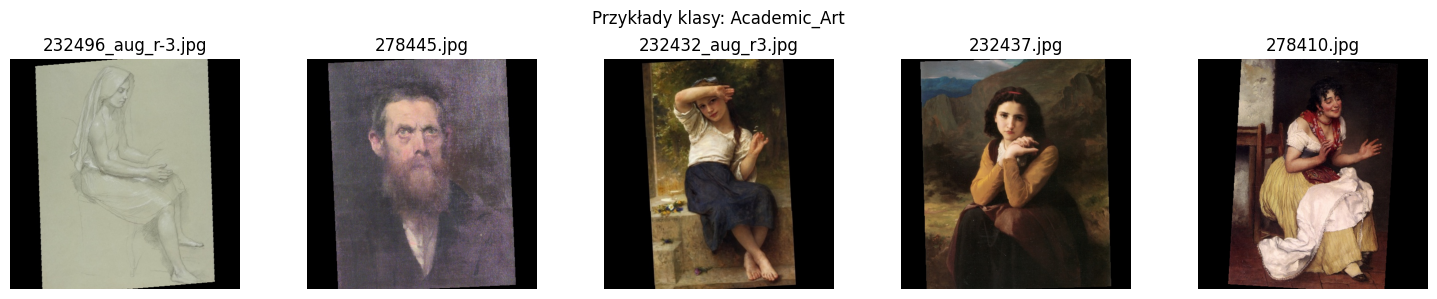

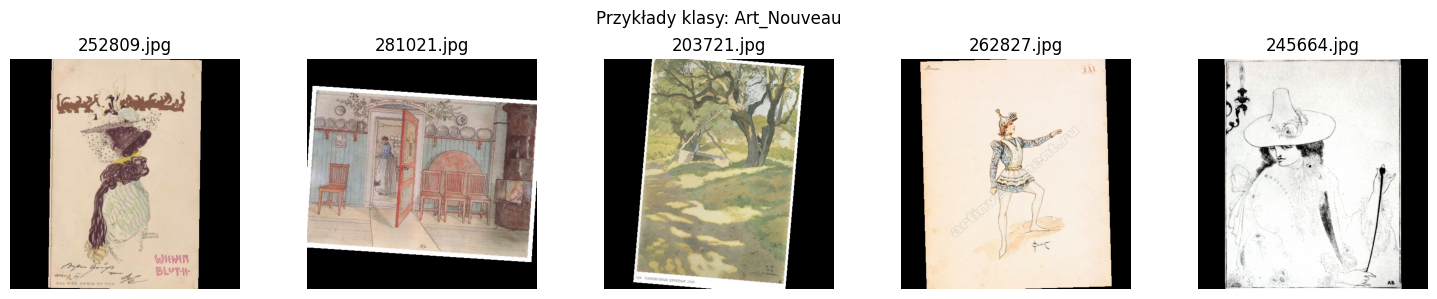

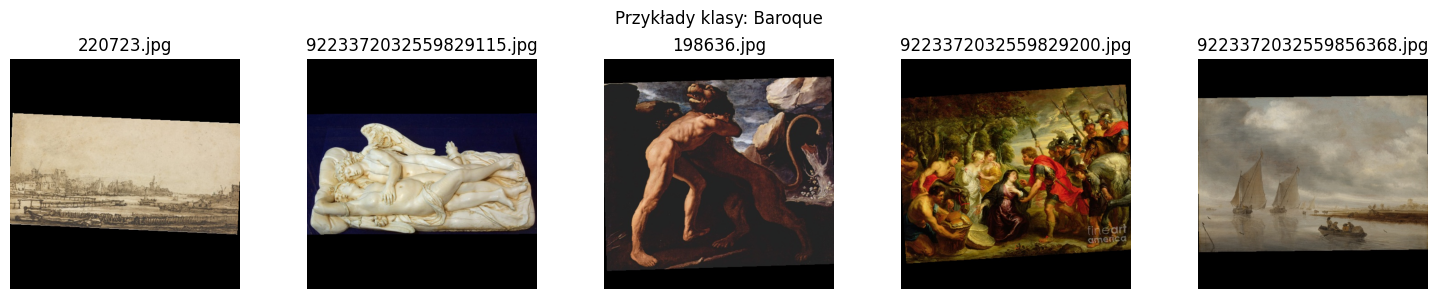

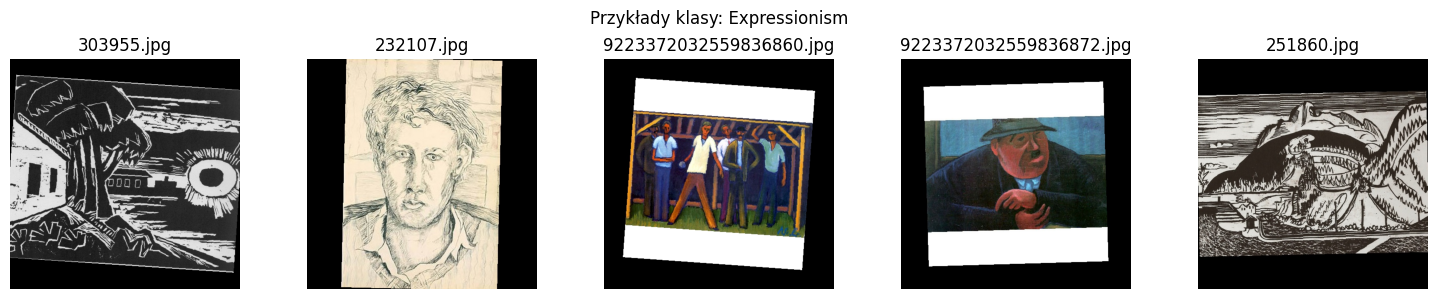

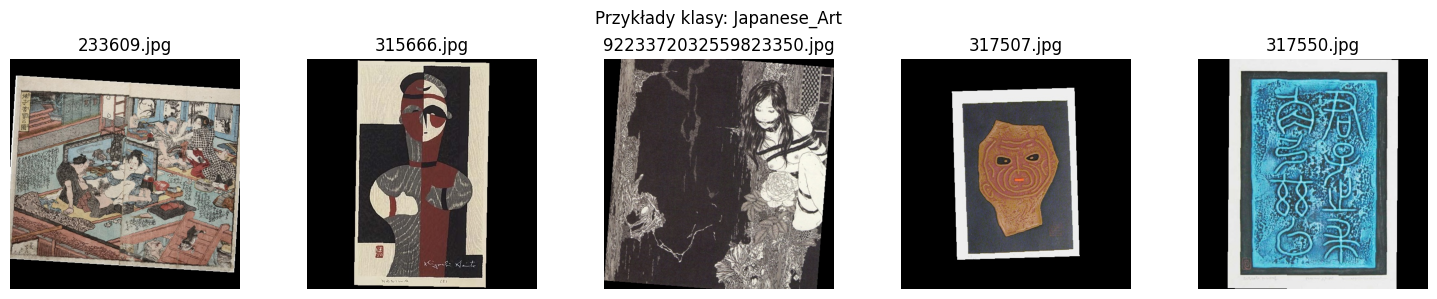

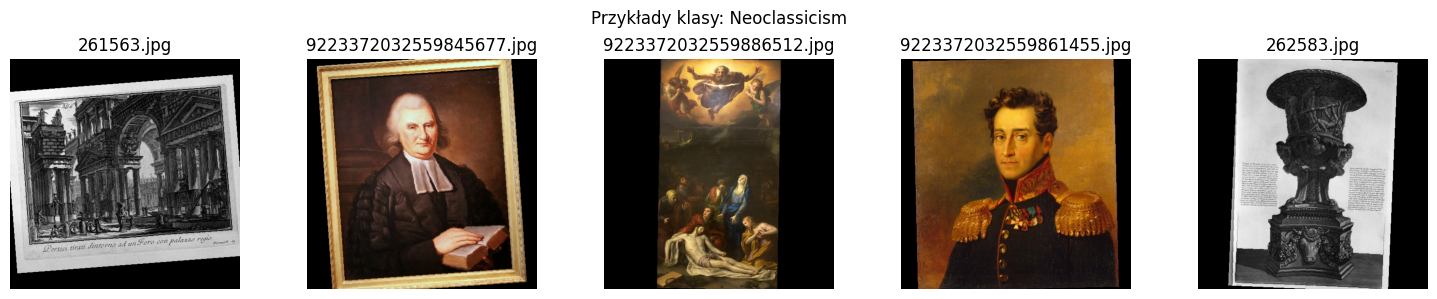

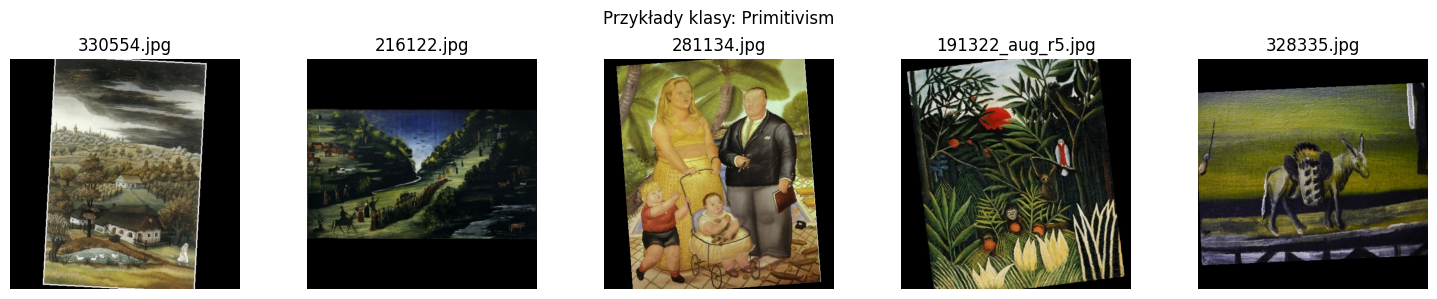

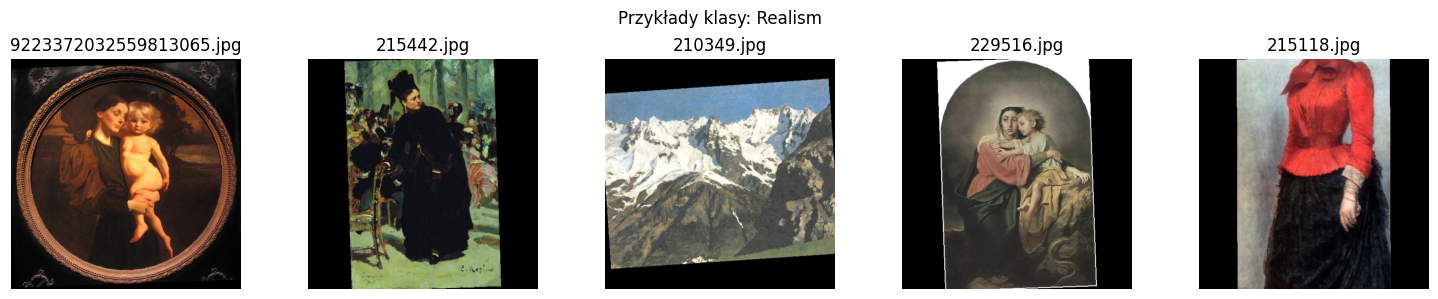

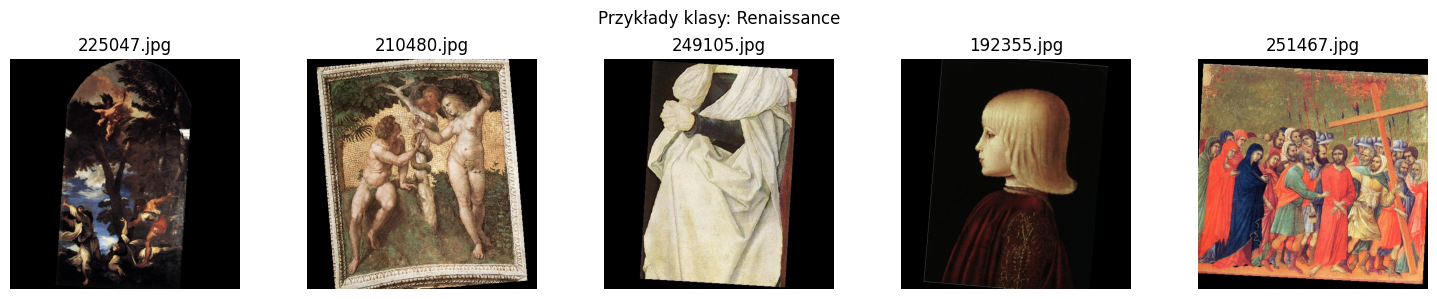

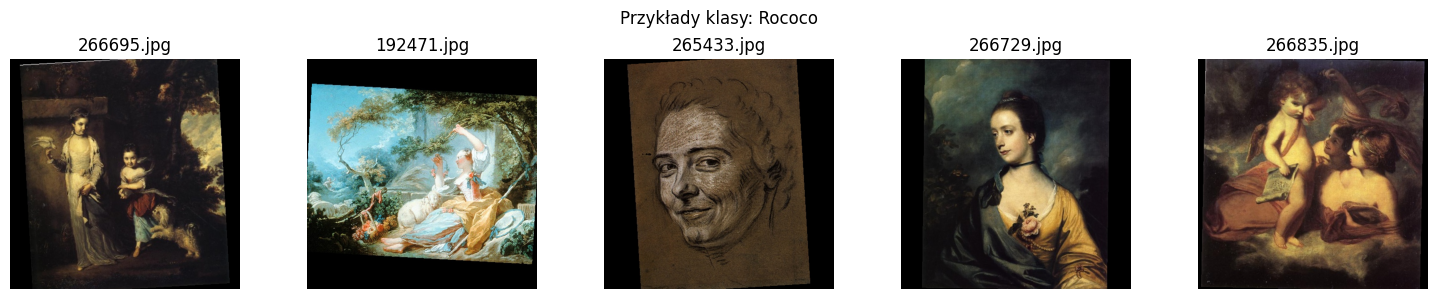

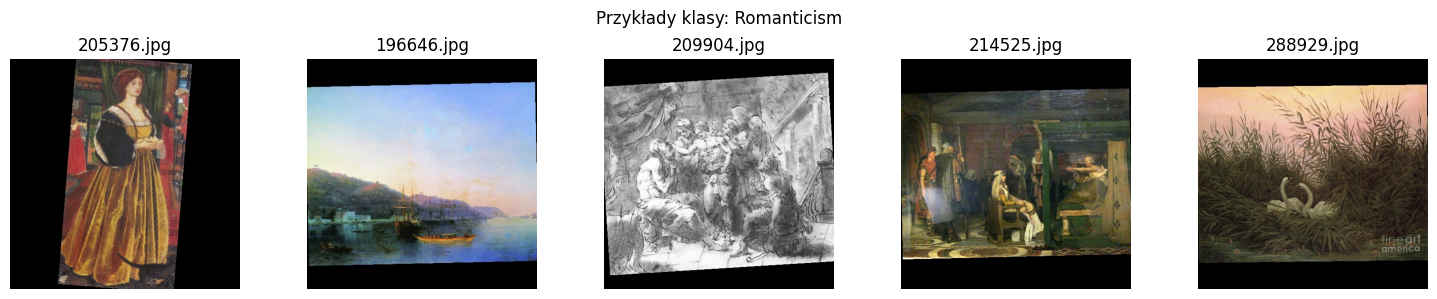

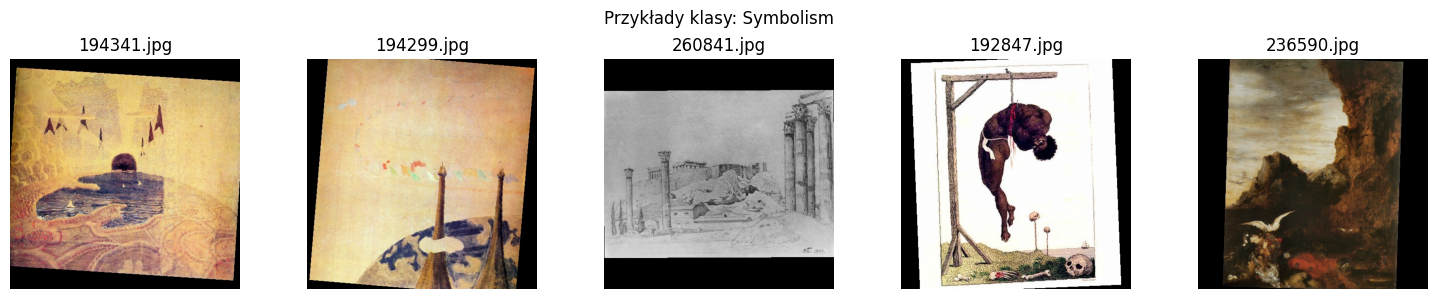

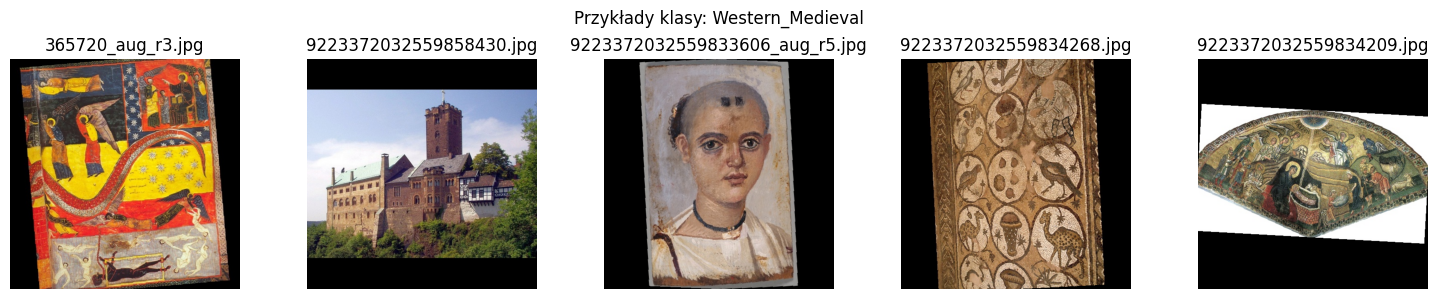

In [18]:
print("\n--- ETAP 5: Wizualizacja przykładów z każdej klasy ---")
plot_class_examples(data_loaders['train_dataset'])

# Własna architektura CNN

In [19]:
import torch.nn as nn
import torch.nn.functional as F

class ArtStyleCNN(nn.Module):
    def __init__(self, num_classes):
        super(ArtStyleCNN, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * (img_size // 8) * (img_size // 8), 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x


# Funkcja treningowa

In [20]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10):
    model = model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        for inputs, labels, _ in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_acc = 100. * correct / total
        val_acc = evaluate_model(model, val_loader, device)

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")


# Funkcja walidacyjna

In [21]:
def evaluate_model(model, loader, device):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for inputs, labels, _ in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    return 100. * correct / total


# Trenowanie

In [23]:
print(torch.__version__)                     # np. 2.6.0+cu118
print(torch.version.cuda)                    # np. '11.8' jeśli CUDA działa
print(torch.cuda.is_available())             # True tylko jeśli działa GPU

2.6.0+cu118
11.8
True


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Używane urządzenie: {device}")

num_classes = len(data_loaders['train_dataset'].label_to_idx)
model = ArtStyleCNN(num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_model(model, 
            data_loaders['train_loader'], 
            data_loaders['val_loader'], 
            criterion, optimizer, 
            device, 
            num_epochs=10)


Używane urządzenie: cuda
